# TODO:
* Are the outputs the actual labels or just the loss (and if so, how do we specify the loss type)
* Turn data into tensor prior to making datasets
* Do we need to add beginning / end tokens to each text sample?

In [1]:
import pandas as pd
import numpy as np
import torch
from pytorch_pretrained_bert import BertForTokenClassification

from transformers import BertTokenizer
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import random

/Users/Gerardo/.virtualenvs/neuro_match/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 31

## Set the random seeds for Python and Torch
random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)

def seed_worker(worker_id): #function to initalize the seeds for the workers of DataLoader
    worker_seed = torch.initial_seed() %2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_seed = torch.Generator()
g_seed.manual_seed(seed)

In [3]:
my_tokenizer = BertTokenizer.from_pretrained("bert-base-cased") #load pre-trained tokenizer

(11531, 3)

Number of samples with more than 512 white spaces: 11531


Text(0.5, 1.0, 'Distribution of white spaces quantity')

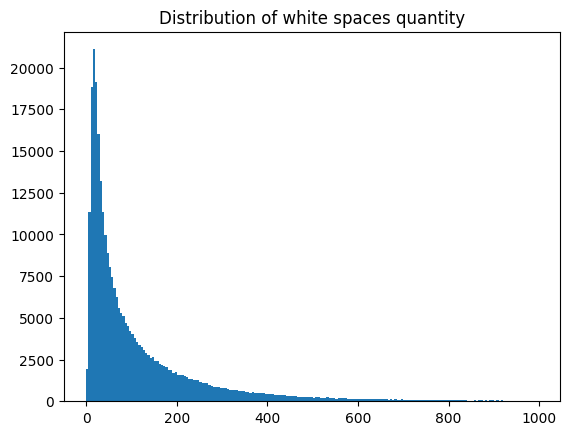

In [17]:
df = pd.read_csv('data/cleandata.csv') #load dataset
df.dropna(inplace = True) #drop nans (4 samples)

# Look at the distribution 
df['string_lengths'] = df['text'].apply(lambda x : len(x.split(' ')))
print(f'Number of samples with more than 512 white spaces: {df[df["string_lengths"] > 512].shape[0]}')
plt.hist(df['string_lengths'],np.arange(0,1000,5)); plt.title('Distribution of white spaces quantity'); plt.xlabel('Number of White Spaces')

In [ ]:
df['text'] = df['text'].apply(lambda x: torch.tensor(my_tokenizer(x)['input_ids'])) #tokenize/tensorize features
df['label'] = torch.tensor(df['label']) #tensorize labels


with open('data/modeling_data','wb') as fid: #save file once it's been pre-processed for easier manipulation
    torch.save(df,fid)

X_train, X_test, y_train, y_test = train_test_split(df['text'],df['label'],test_size = 0.2) #split into train_test

In [55]:
#Define Hyperparameters
batch_size = 128
lr = 0.01

In [ ]:
test_data = TensorDataset(X_test,y_test)
train_data = TensorDataset(X_train, y_train)

test_loader = DataLoader(test_data,batch_size = batch_size , shuffle = False, num_workers = 0, worker_init_fn = seed_worker, generator = g_seed)
train_loader = DataLoader(train_data,batch_size = batch_size , drop_last = True, shuffle = True, worker_init_fn = seed_worker, generator = g_seed)

In [ ]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels = 2) ##Loading a pre-trained BERT model
my_optim = SGD(model.parameters(), lr=lr)
my_loss = CrossEntropyLoss() #we might not need this, since the link in the word docuemt says that running the model returns a loss

model.train() #set the model to train mode


In [ ]:
my_optim.zero_grad()

y_pred,something_else = model(X_train)

my_loss(y_pred,y_train)

my_loss.backward()
my_optim.step()

